In [23]:
import pandas as pd
import numpy as np

from tqdm import tqdm
from itertools import combinations, islice
from scipy import stats
from collections import defaultdict

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics, preprocessing

from news_vec.corpus import Corpus
from news_vec.utils import read_json_gz_lines

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import altair as alt
import seaborn as sns

mpl.style.use('seaborn-muted')
sns.set(style="whitegrid")

%matplotlib inline

In [11]:
class Actors:
    
    def __init__(self, root, skim=None):
        self.root = root
        self.skim = skim
        
    def __iter__(self):
        reader = islice(read_json_gz_lines(self.root), self.skim)
        yield from tqdm(reader)

In [65]:
actors = Actors('../data/clf-actors.json/')

In [66]:
next(iter(actors))

0it [00:00, ?it/s]


{'actor_id': 'id:twitter.com:2793391472',
 'article_id': 37255,
 'domain': 'apnews.com',
 'ts_bucket': 7}

In [33]:
ARTICLE_ACTORS = defaultdict(set)
DOMAIN_ACTORS = defaultdict(set)

for r in actors:
    ARTICLE_ACTORS[r['article_id']].add(r['actor_id'])
    DOMAIN_ACTORS[r['domain']].add(r['actor_id'])

76224508it [07:25, 171013.90it/s]


In [43]:
def article_domain_actor_pct(article_id, domain):
    actors = ARTICLE_ACTORS[article_id]
    actors_domain = [aid for aid in actors if aid in DOMAIN_ACTORS[domain]]
    return len(actors_domain) / len(actors)

In [3]:
corpus = Corpus('../data/clf-headlines.json/')

2018-12-29 12:07:07,744 | INFO : Reading headlines.
1225511it [00:15, 79302.01it/s] 


In [84]:
def pred_ab(d1, d2):
    
    df = corpus.sample_ab(d1, d2)

    tv = TfidfVectorizer(
        analyzer='word',
        tokenizer=lambda x: x,
        preprocessor=lambda x: x,
        token_pattern=None,
        ngram_range=(1,3)
    )

    df_train, df_test = train_test_split(df)

    X_train = tv.fit_transform(df_train.clf_tokens)
    X_test = tv.transform(df_test.clf_tokens)

    clf = LogisticRegression(solver='lbfgs')
    fit = clf.fit(X_train, df_train.domain)

    df_test = df_test.copy()
    
    df_test['p_true'] = [
        p[0] if d==fit.classes_[0] else p[1]
        for p, d in zip(fit.predict_proba(X_test), df_test.domain)
    ]
    
    df_test['p_false'] = 1 - df_test.p_true
    
    df_test['b_domain'] = df_test.domain.apply(lambda d: d1 if d==d2 else d2)
    df_test['b_actor_pct'] = df_test.apply(lambda r: article_domain_actor_pct(r.article_id, r.b_domain), 1)
    df_test['b_actor_pct_scaled'] = preprocessing.scale(df_test.b_actor_pct)
    
    return df_test

In [85]:
def pf_bpct_corr(pred_df, domain):
    df = pred_df[pred_df.domain==domain].copy()
    corr, p = stats.pearsonr(df.p_false, df.b_actor_pct)
    return corr, p, df

In [98]:
def plot_sl_audience(d1, d2):
    
    pred_df = pred_ab(d1, d2)
    corr, p, ddf = pf_bpct_corr(pred_df, d1)
    
    plt.figure(figsize=(10,5))
    
    print(corr, p)
    
    sns.jointplot(
        y='b_actor_pct',
        x='p_false',
        data=ddf,
        height=10,
        kind='reg',
        scatter_kws=dict(s=1),
    )
    
    plt.show()
    
    return pred_df

0.3801065531581789 1.6157820134147333e-229


<Figure size 720x360 with 0 Axes>

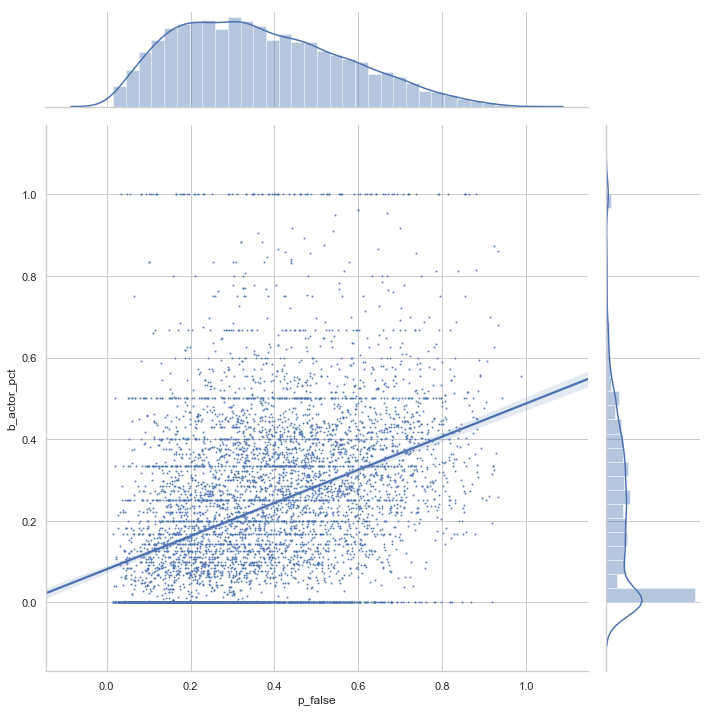

In [99]:
_ = plot_sl_audience('huffingtonpost.com', 'dailycaller.com')

-0.0371834421283875 0.002358741736923398


<Figure size 720x360 with 0 Axes>

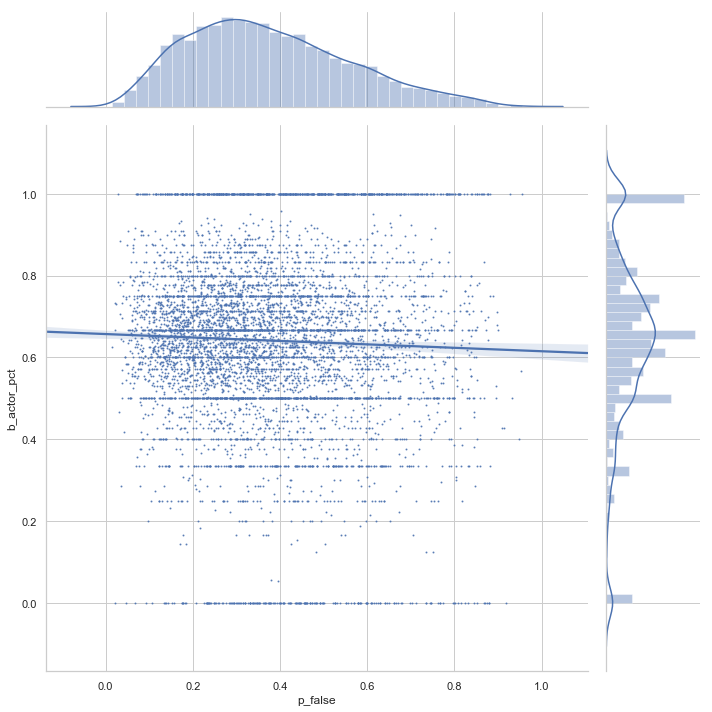

In [100]:
_ = plot_sl_audience('dailycaller.com', 'huffingtonpost.com')

0.25370889795502166 4.0880138469252225e-99


<Figure size 720x360 with 0 Axes>

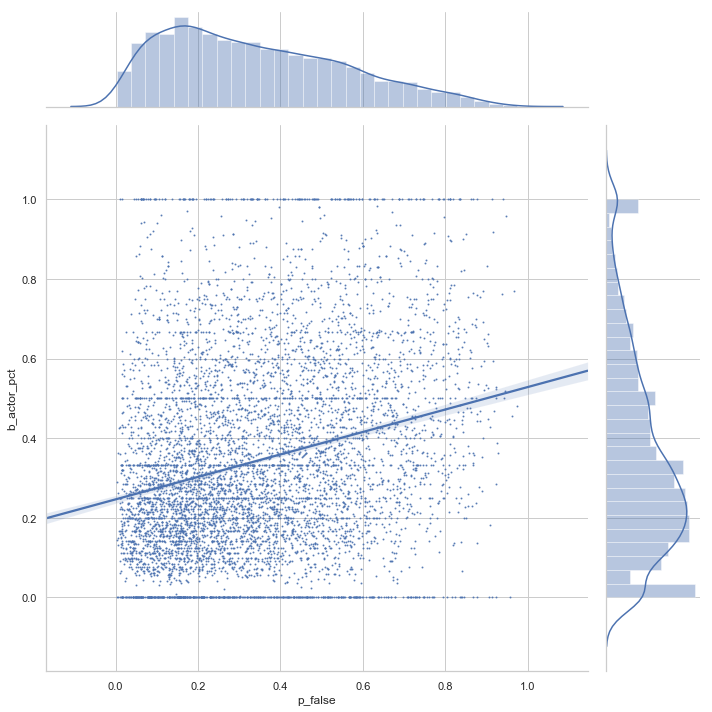

In [101]:
_ = plot_sl_audience('nytimes.com', 'foxnews.com')

-0.08680396773820767 7.456792941590091e-13


<Figure size 720x360 with 0 Axes>

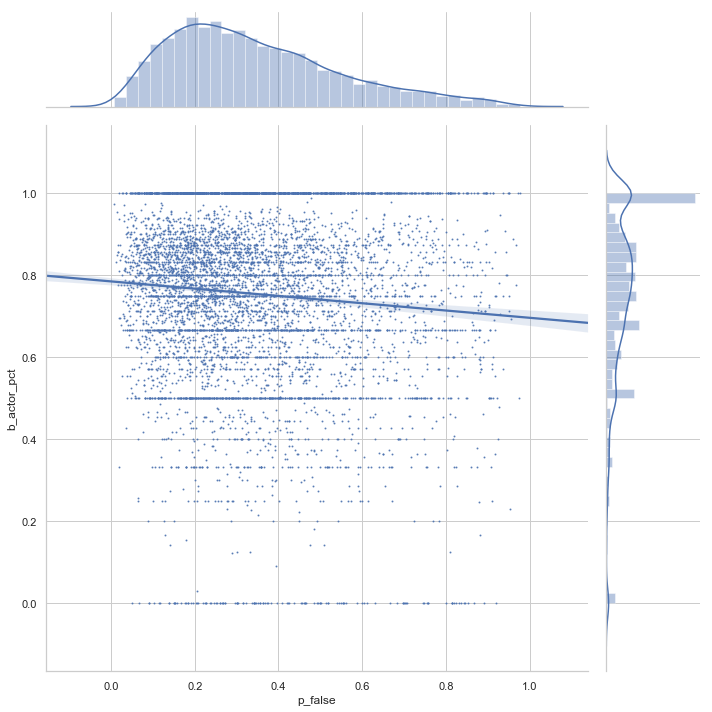

In [102]:
_ = plot_sl_audience('foxnews.com', 'nytimes.com')

0.36521573465938256 6.452656774782701e-212


<Figure size 720x360 with 0 Axes>

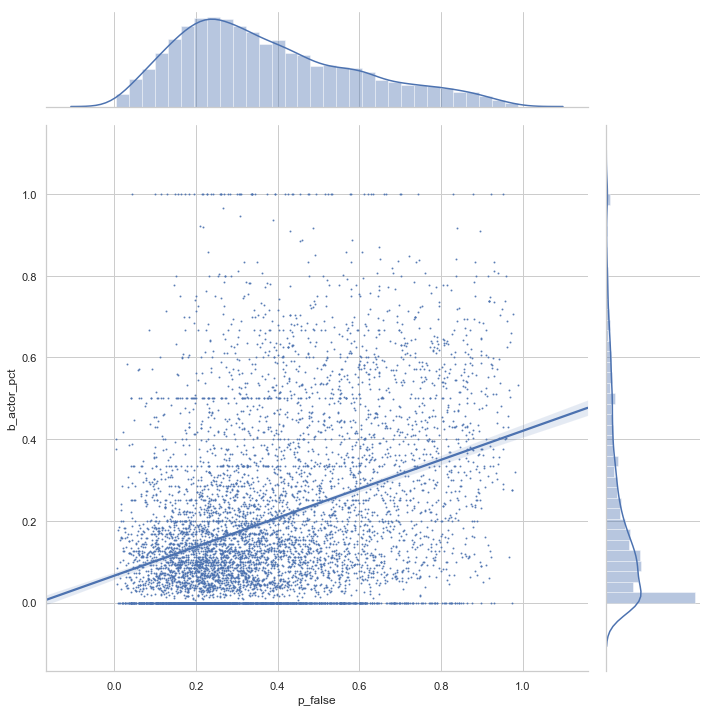

In [103]:
_ = plot_sl_audience('nytimes.com', 'dailykos.com')

-0.06847849741480753 1.9193406744352625e-08


<Figure size 720x360 with 0 Axes>

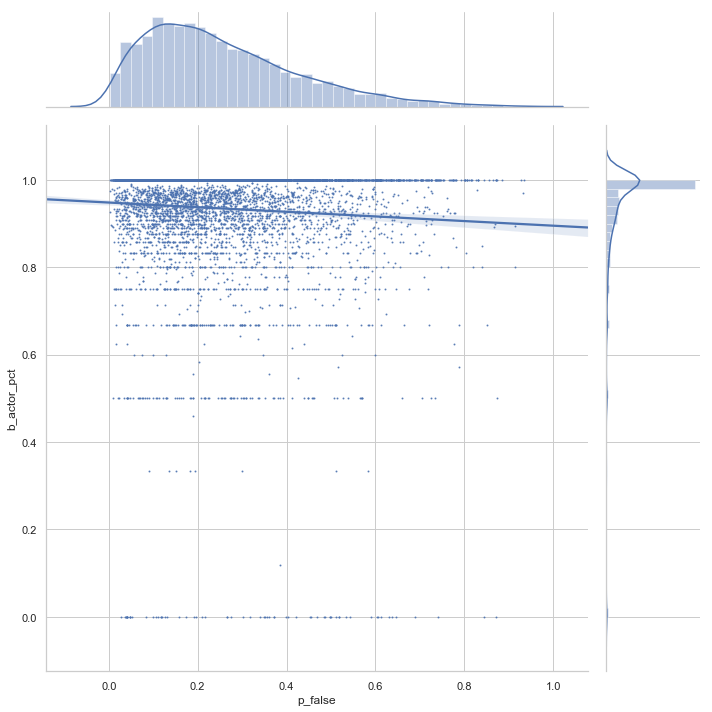

In [104]:
_ = plot_sl_audience('dailykos.com', 'nytimes.com')

0.5070684882575301 0.0


<Figure size 720x360 with 0 Axes>

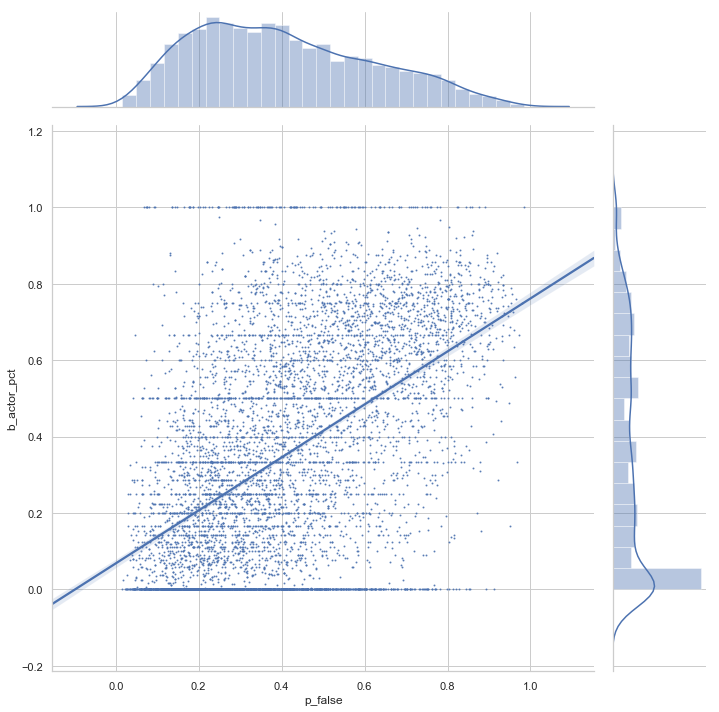

In [105]:
_ = plot_sl_audience('huffingtonpost.com', 'dailykos.com')

-0.06296287714540216 2.497484188007173e-07


<Figure size 720x360 with 0 Axes>

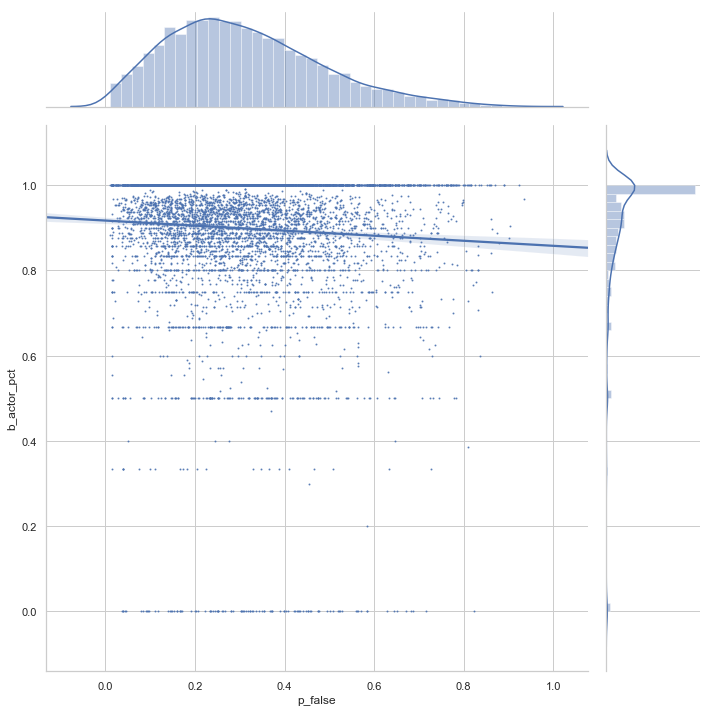

In [106]:
_ = plot_sl_audience('dailykos.com', 'huffingtonpost.com')

0.04004922283320974 0.0009706963190379584


<Figure size 720x360 with 0 Axes>

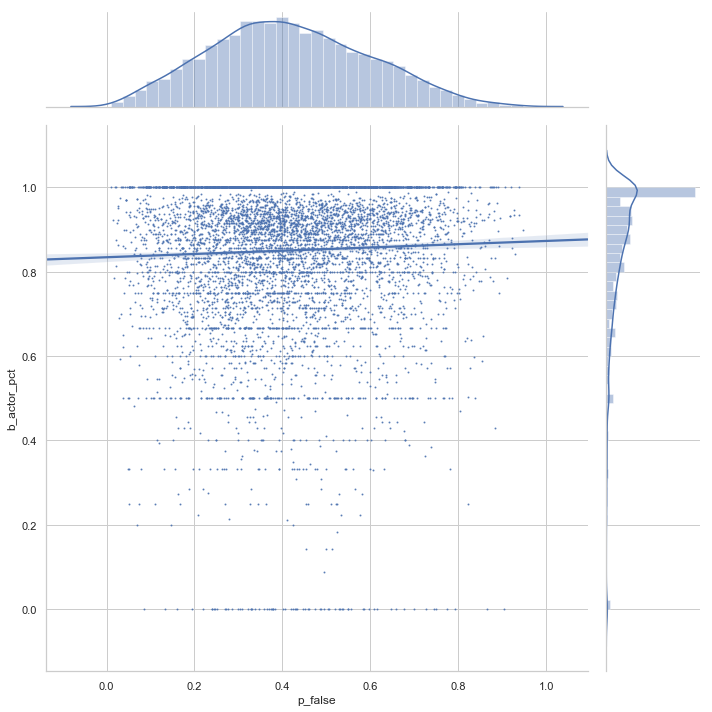

In [107]:
_ = plot_sl_audience('breitbart.com', 'dailycaller.com')

0.020592517770469346 0.08991508661109078


<Figure size 720x360 with 0 Axes>

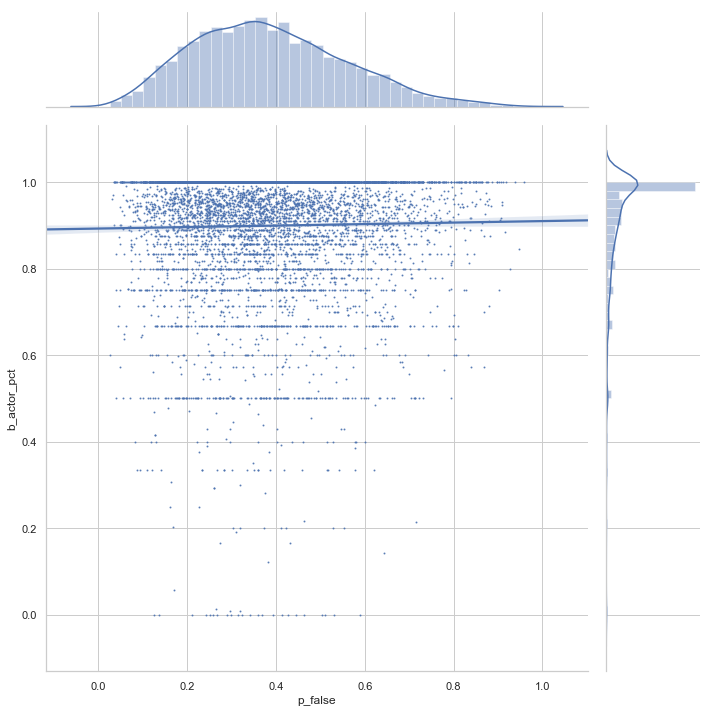

In [108]:
_ = plot_sl_audience('dailycaller.com', 'breitbart.com')